# 图像分类数据集
:label:`sec_fashion_mnist`

目前广泛使用的图像分类数据集之一是 MNIST 数据集 :cite:`LeCun.Bottou.Bengio.ea.1998`。虽然它是很不错的基准数据集，但按今天的标准，即使是简单的模型也能达到95%以上的分类准确率，因此不适合区分强模型和弱模型。如今，MNIST更像是一个健全检查，而不是一个基准。
为了提高难度，我们将在接下来的章节中讨论在2017年发布的性质相似但相对复杂的Fashion-MNIST数据集 :cite:`Xiao.Rasul.Vollgraf.2017`。


In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()


## 读取数据集

我们可以通过框架中的内置函数将 Fashion-MNIST 数据集下载并读取到内存中。


In [3]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式
# 并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True,
                                                transform=trans,
                                                download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False,
                                               transform=trans, download=True)

Fashion-MNIST 由 10 个类别的图像组成，每个类别由训练数据集中的 6000 张图像和测试数据集中的 1000 张图像组成。*测试数据集*（test dataset）不会用于训练，只用于评估模型性能。训练集和测试集分别包含 60000 和 10000 张图像。


In [4]:
len(mnist_train), len(mnist_test)

(60000, 10000)

每个输入图像的高度和宽度均为 28 像素。数据集由灰度图像组成，其通道数为1。为了简洁起见，在这本书中，我们将高度$h$像素，宽度$w$像素图像的形状记为$h \times w$或($h$, $w$)。


In [5]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

Fashion-MNIST中包含的10个类别分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数用于在数字标签索引及其文本名称之间进行转换。


In [6]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签。"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

我们现在可以创建一个函数来可视化这些样本。


In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

以下是训练数据集中前几个样本的图像及其相应的标签（文本形式）。


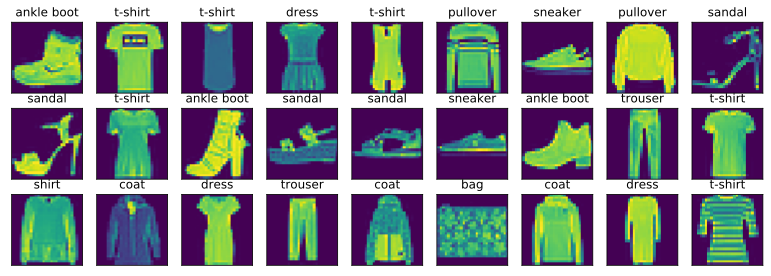

In [8]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=27)))
show_images(X.reshape(27, 28, 28), 3, 9, titles=get_fashion_mnist_labels(y));

## 读取小批量

为了使我们在读取训练集和测试集时更容易，我们使用内置的数据迭代器，而不是从零开始创建一个。
回顾一下，在每次迭代中，数据加载器每次都会读取一小批量数据，大小为`batch_size`。我们在训练数据迭代器中还随机打乱了所有样本。


In [ ]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取的数据。"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())
                             # batch_size (int, optional) – 每个batch加载多少个样本(默认: 1)。
                             # shuffle (bool, optional) – 设置为True时会在每个epoch重新打乱数据(默认: False).


让我们看一下读取训练数据所需的时间。


In [12]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'3.14 sec'

In [13]:
i=1
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    if i>2:
        break
    i+=1
    continue

# X的形状256表示一个batch，然后则是一张图片的形状

torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64
torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64
torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64


## 整合所有组件

现在我们定义了 `load_data_fashion_mnist` 函数，用于获取和读取Fashion-MNIST数据集。它返回训练集和验证集的数据迭代器。此外，它还接受一个可选参数，用来将图像大小调整为另一种形状。


In [14]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    # 接受一个可选参数，用来将图像大小调整为另一种形状。
    if resize:
        # transforms对PIL.Image进行变换 Resize重置图像分辨率
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

下面，我们通过指定`resize`参数来测试`load_data_fashion_mnist`函数的图像大小调整功能。


In [26]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


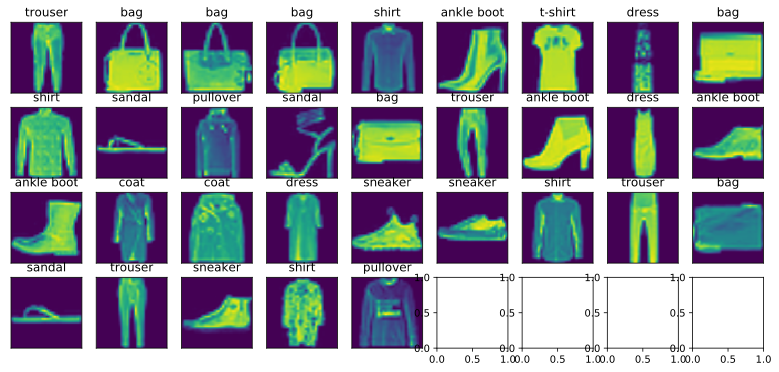

In [27]:
#554
X, y = next(iter(train_iter))
show_images(X.reshape(32, 64, 64), 4, 9, titles=get_fashion_mnist_labels(y));

我们现在已经准备好在下面的章节中使用Fashion-MNIST数据集。

## 小结

* Fashion-MNIST是一个服装分类数据集，由10个类别的图像组成。我们将在后续章节中使用此数据集来评估各种分类算法。
* 我们将高度$h$像素，宽度$w$像素图像的形状记为$h \times w$或($h$, $w$)。
* 数据迭代器是获得更高性能的关键组件。依靠实现良好的数据迭代器，利用高性能计算来避免减慢训练过程。

## 练习

1. 减少 `batch_size`（如减少到 1）是否会影响读取性能？
1. 数据迭代器的性能非常重要。你认为当前的实现足够快吗？探索各种选择来改进它。
1. 查阅框架的在线API文档。还有哪些其他数据集可用？


[Discussions](https://discuss.d2l.ai/t/1787)
